In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
import pandas as pd
time_data = pd.read_csv(r'../Dataset/2nd_Wave_Dataset.csv', header=None)

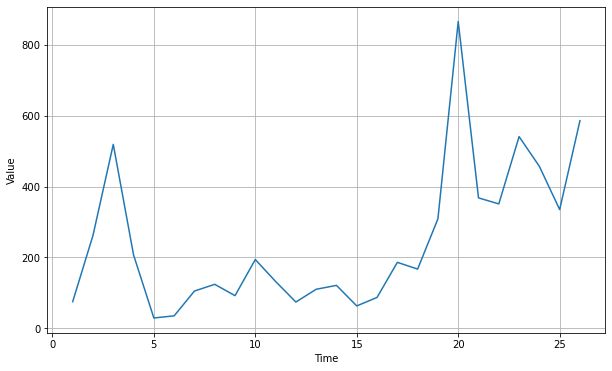

In [4]:
import csv
time_step = []
covid = []
step = 1

with open(r'../Dataset/2nd_Wave_dataset.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        covid.append(float(row[1]))
        time_step.append(step)
        step += 1
        
series = np.array(covid)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
len(series)

26

In [ ]:
w1 = 1,2,3,4,5
w2 = 2,3,4,5,6

In [7]:
split_time = 22
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 3 ##changed from 22 to 3
shuffle_buffer_size = 20

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = window_size
batch_size = batch_size
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(20, return_sequences=True),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(22,)
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [==============================] - 0s 41ms/step - loss: 218.6411 - mae: 219.1411
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 218.6179 - mae: 219.1179
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 218.5732 - mae: 219.0732
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 218.5084 - mae: 219.0084
Epoch 5/100
1/1 [======

Epoch 77/100
1/1 [==============================] - 0s 1ms/step - loss: 119.3099 - mae: 119.8099
Epoch 78/100
1/1 [==============================] - 0s 1ms/step - loss: 119.2135 - mae: 119.7135
Epoch 79/100
1/1 [==============================] - 0s 1ms/step - loss: 119.0993 - mae: 119.5993
Epoch 80/100
1/1 [==============================] - 0s 1ms/step - loss: 118.9504 - mae: 119.4504
Epoch 81/100
1/1 [==============================] - 0s 925us/step - loss: 118.7664 - mae: 119.2664
Epoch 82/100
1/1 [==============================] - 0s 2ms/step - loss: 118.6345 - mae: 119.1258
Epoch 83/100
1/1 [==============================] - 0s 1ms/step - loss: 118.5250 - mae: 119.0250
Epoch 84/100
1/1 [==============================] - 0s 908us/step - loss: 118.6661 - mae: 119.1661
Epoch 85/100
1/1 [==============================] - 0s 949us/step - loss: 124.2530 - mae: 124.7530
Epoch 86/100
1/1 [==============================] - 0s 955us/step - loss: 135.1015 - mae: 135.6015
Epoch 87/100
1/1 [====

(1e-08, 0.0001, 0.0, 1000.0)

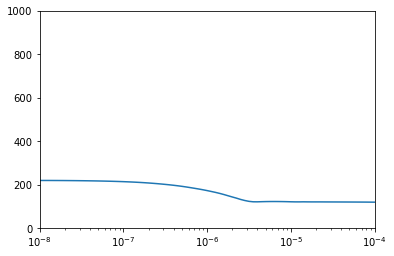

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 1000])

In [80]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=10, kernel_size=3, strides=1, padding="same", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(44, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(22, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(11, return_sequences=True)),
  #tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(30, activation="tanh"),
  tf.keras.layers.Dense(15, activation="tanh"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
1/1 [==============================] - 0s 12ms/step - loss: 162.8775 - mae: 163.3775
Epoch 2/500
1/1 [==============================] - 0s 948us/step - loss: 276.0782 - mae: 276.5782
Epoch 3/500
1/1 [==============================] - 0s 880us/step - loss: 220.8649 - mae: 221.3649
Epoch 4/500
1/1 [==============================] - 0s 864us/step - loss: 180.7815 - mae: 181.2815
Epoch 5/500
1/1 [==============================] - 0s 750us/step - loss: 153.4064 - mae: 153.9064
Epoch 6/500
1/1 [==============================] - 0s 853us/step - loss: 121.5829 - mae: 122.0829
Epoch 7/500
1/1 [==============================] - 0s 877us/step - loss: 136.1285 - mae: 136.6285
Epoch 8/500
1/1 [==============================] - 0s 994us/step - loss: 119.7221 - mae: 120.2220
Epoch 9/500
1/1 [==============================] - 0s 1ms/step - loss: 115.6991 - mae: 116.1987
Epoch 10/500
1/1 [==============================] - 0s 1ms/step - loss: 104.2700 - mae: 104.7699
Epoch 11/500
1/1 [======

1/1 [==============================] - 0s 746us/step - loss: 55.6608 - mae: 56.1608
Epoch 86/500
1/1 [==============================] - 0s 812us/step - loss: 29.4042 - mae: 29.9042
Epoch 87/500
1/1 [==============================] - 0s 780us/step - loss: 54.8541 - mae: 55.3541
Epoch 88/500
1/1 [==============================] - 0s 666us/step - loss: 53.6048 - mae: 54.1048
Epoch 89/500
1/1 [==============================] - 0s 724us/step - loss: 28.1221 - mae: 28.6212
Epoch 90/500
1/1 [==============================] - 0s 899us/step - loss: 46.9631 - mae: 47.4536
Epoch 91/500
1/1 [==============================] - 0s 783us/step - loss: 50.8440 - mae: 51.3440
Epoch 92/500
1/1 [==============================] - 0s 822us/step - loss: 33.8746 - mae: 34.3630
Epoch 93/500
1/1 [==============================] - 0s 814us/step - loss: 78.7608 - mae: 79.2608
Epoch 94/500
1/1 [==============================] - 0s 735us/step - loss: 33.7516 - mae: 34.2442
Epoch 95/500
1/1 [=========================

1/1 [==============================] - 0s 869us/step - loss: 12.0534 - mae: 12.5398
Epoch 169/500
1/1 [==============================] - 0s 754us/step - loss: 12.5390 - mae: 13.0360
Epoch 170/500
1/1 [==============================] - 0s 865us/step - loss: 20.1950 - mae: 20.6950
Epoch 171/500
1/1 [==============================] - 0s 744us/step - loss: 39.7449 - mae: 40.2449
Epoch 172/500
1/1 [==============================] - 0s 863us/step - loss: 13.6110 - mae: 14.1104
Epoch 173/500
1/1 [==============================] - 0s 747us/step - loss: 53.9641 - mae: 54.4641
Epoch 174/500
1/1 [==============================] - 0s 893us/step - loss: 12.5333 - mae: 13.0166
Epoch 175/500
1/1 [==============================] - 0s 817us/step - loss: 90.3667 - mae: 90.8667
Epoch 176/500
1/1 [==============================] - 0s 760us/step - loss: 93.7972 - mae: 94.2972
Epoch 177/500
1/1 [==============================] - 0s 787us/step - loss: 20.2645 - mae: 20.7631
Epoch 178/500
1/1 [===============

1/1 [==============================] - 0s 854us/step - loss: 42.5571 - mae: 43.0571
Epoch 252/500
1/1 [==============================] - 0s 828us/step - loss: 25.4228 - mae: 25.9228
Epoch 253/500
1/1 [==============================] - 0s 799us/step - loss: 44.3021 - mae: 44.8021
Epoch 254/500
1/1 [==============================] - 0s 777us/step - loss: 29.8918 - mae: 30.3897
Epoch 255/500
1/1 [==============================] - 0s 1ms/step - loss: 43.4744 - mae: 43.9744
Epoch 256/500
1/1 [==============================] - 0s 919us/step - loss: 48.5474 - mae: 49.0457
Epoch 257/500
1/1 [==============================] - 0s 819us/step - loss: 20.3874 - mae: 20.8874
Epoch 258/500
1/1 [==============================] - 0s 1ms/step - loss: 32.4206 - mae: 32.9206
Epoch 259/500
1/1 [==============================] - 0s 1ms/step - loss: 14.9517 - mae: 15.4495
Epoch 260/500
1/1 [==============================] - 0s 2ms/step - loss: 20.9753 - mae: 21.4753
Epoch 261/500
1/1 [=======================

1/1 [==============================] - 0s 808us/step - loss: 20.7735 - mae: 21.2576
Epoch 336/500
1/1 [==============================] - 0s 760us/step - loss: 13.9575 - mae: 14.4418
Epoch 337/500
1/1 [==============================] - 0s 751us/step - loss: 30.7654 - mae: 31.2654
Epoch 338/500
1/1 [==============================] - 0s 790us/step - loss: 14.6078 - mae: 15.1078
Epoch 339/500
1/1 [==============================] - 0s 767us/step - loss: 23.6513 - mae: 24.1513
Epoch 340/500
1/1 [==============================] - 0s 786us/step - loss: 9.4848 - mae: 9.9784
Epoch 341/500
1/1 [==============================] - 0s 772us/step - loss: 27.3640 - mae: 27.8520
Epoch 342/500
1/1 [==============================] - 0s 925us/step - loss: 17.1214 - mae: 17.6209
Epoch 343/500
1/1 [==============================] - 0s 2ms/step - loss: 32.3401 - mae: 32.8401
Epoch 344/500
1/1 [==============================] - 0s 854us/step - loss: 11.5987 - mae: 12.0956
Epoch 345/500
1/1 [===================

1/1 [==============================] - 0s 785us/step - loss: 24.5348 - mae: 25.0348
Epoch 420/500
1/1 [==============================] - 0s 812us/step - loss: 29.8979 - mae: 30.3979
Epoch 421/500
1/1 [==============================] - 0s 811us/step - loss: 19.6998 - mae: 20.1997
Epoch 422/500
1/1 [==============================] - 0s 802us/step - loss: 25.7317 - mae: 26.2317
Epoch 423/500
1/1 [==============================] - 0s 851us/step - loss: 16.5376 - mae: 17.0302
Epoch 424/500
1/1 [==============================] - 0s 793us/step - loss: 17.2546 - mae: 17.7498
Epoch 425/500
1/1 [==============================] - 0s 828us/step - loss: 18.2956 - mae: 18.7907
Epoch 426/500
1/1 [==============================] - 0s 1ms/step - loss: 14.5622 - mae: 15.0535
Epoch 427/500
1/1 [==============================] - 0s 777us/step - loss: 15.8040 - mae: 16.3039
Epoch 428/500
1/1 [==============================] - 0s 780us/step - loss: 13.1367 - mae: 13.6106
Epoch 429/500
1/1 [=================

In [81]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

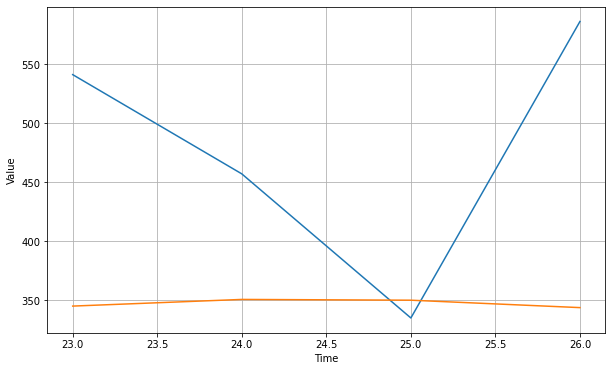

In [82]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [83]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

139.88019

<Figure size 432x288 with 0 Axes>

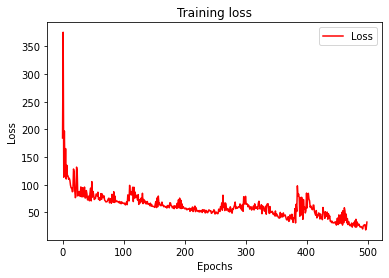

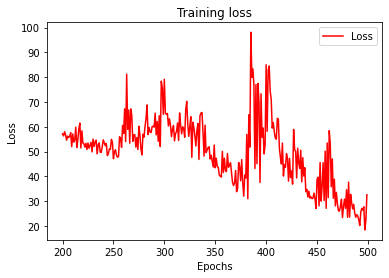

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [19]:
print(rnn_forecast)

[365.02213 377.68683 411.60345 362.54483]


In [196]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 7)           28        
_________________________________________________________________
bidirectional (Bidirectional (None, None, 80)          11760     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 60)          20160     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 40)          9840      
_________________________________________________________________
dense (Dense)                (None, None, 35)          1435      
_________________________________________________________________
dense_1 (Dense)              (None, None, 22)          792       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           2